In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
class MLPClassifier_pytorch:
    
    
    def __init__(self, input_dim):
        self.input_dim = input_dim
        self.model = self.MLP(self.input_dim)

    import torch.nn.functional as F
    
    class MLP(torch.nn.Module):
        
        def __init__(self, input_dim, output_dim=11):
            super().__init__()

            self.input_fc = torch.nn.Linear(input_dim, 1024)
            self.output_fc = torch.nn.Linear(1024, output_dim)

        def forward(self, x):

            # x = [batch size, height, width]

            batch_size = x.shape[0]
            # feat_dim = x.shape[-1]
            
            x = x.view(batch_size,-1)

            # x = [batch size, height * width]

            h_1 = torch.nn.functional.relu(self.input_fc(x))

            y_pred = self.output_fc(h_1)

            y_pred = torch.nn.functional.softmax(y_pred, dim=1)
            # y_pred = [batch size, output dim]

            return y_pred
    
    def calculate_accuracy(self, y_pred, y):

        top_pred = y_pred.argmax(1, keepdim=True)
        correct = top_pred.eq(y.view_as(top_pred)).sum()
        acc = correct.float() / y.shape[0]

        return acc.numpy()


    def train(self, x, y, model, optimizer, criterion, device):


        x_ = torch.from_numpy(x).to(device).float()
        import torch.nn.functional as f
        y_ = torch.from_numpy(y).type(torch.LongTensor).to(device).float()
        
        epoch_loss = 0
        epoch_acc = 0

        model.train()

        optimizer.zero_grad()

        y_pred = model(x_)
       
        y_ = y_.type(torch.LongTensor)
        
        # y_special = F.one_hot(y_, num_classes=11)
        loss = criterion(y_pred, y_)

        acc = self.calculate_accuracy(y_pred, y_)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        return 1
    
    
    def fit(self, X_train, Y_train):
        device = torch.device('cpu')

        self.model = self.model.to(device)
        
        num_epochs = 10
        
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

        for n in range(num_epochs):
            self.train(X_train, Y_train, self.model, optimizer, criterion, device)
        
        return self
        
    def predict(self, x):
        device = torch.device('cpu')
        x_ = torch.from_numpy(x).to(device).float()
        y_ = self.model(x_)
        y_ret = y_.detach().cpu().numpy()
        
        y_ret = np.argmax(y_ret, axis=1)
        
        return y_ret

In [18]:
from sklearn.decomposition import PCA

def do_everything(selection, ooi_data):

    # selection = ['scr', 'mr']
    # selection = ['lr']
    # selection = ['scr']
    import pickle as pkl

    import io
    import torch

    all_labels = []

    for d in ooi_data:
        temp_labels = []
        
        for r in d['relations']:
            rels = r[1]
            
            # for k in selection:
            #     temp_labels+=rels[k]
            
            temp_labels+=rels['scr']
            temp_labels+=rels['lr']
            temp_labels+=rels['mr']
            
        all_labels+= temp_labels
            
    unique_labels = list(set(all_labels))
    labels_enumeration = {}
    
    
    for i, u in enumerate(unique_labels):
        
        if u == '':
            continue
        labels_enumeration[u] = i-1

    # print(labels_enumeration)
    all_videos = []
    vid_to_class = {}

    for d in ooi_data:
        all_videos.append( d['metadata']['yt_id'] )
        vid_to_class[ d['metadata']['yt_id'] ] = d['metadata']['activity name']

    unique_videos = list(set(all_videos))
    videos_enumeration = {}

    for i, u in enumerate(unique_videos):
        
        videos_enumeration[u] = i

    # print(videos_enumeration)
    # print(vid_to_class)
    activity_enumeration = {'AssembleCabinet': 0, 'ChangeCarTire': 1, 'FuelCar': 2, 'InstallBicycleRack': 3,
    'InstallShowerHead': 4, 'ParkParallel': 5, 'ReplaceDoorKnob': 6, 'ReplaceToiletSeat': 7,
    'UseJack': 8, 'PolishCar': 9, 'ReplaceBatteryOnTVControl': 10}
    import numpy as np

    def make_hoi_features(ooi_data, videos_enumeration, labels_enumeration, activity_enumeration,  vid_to_class_map
                        , hoi_ooi_both='hoi'):

        num_rows = len( list(videos_enumeration.keys()) )
        num_cols = len( list(labels_enumeration.keys()) )
        
        X = np.zeros((num_rows, num_cols))
        Y = np.zeros(num_rows)
        num_gifs_for_each_vid = np.zeros(num_rows)
        
        num_gifs = len(ooi_data)
        
        for i in range(num_gifs):

            curr_vid = ooi_data[i]['metadata']['yt_id']
            curr_activity = vid_to_class_map[curr_vid]
            curr_activity_enumeration = activity_enumeration[curr_activity]

            curr_row = videos_enumeration[curr_vid]
            
            Y[curr_row] = curr_activity_enumeration
            
            
            objs = ooi_data[i]['bboxes']
            
            human_boxes = []
            obj_keys = list(objs.keys())
            
            for o in obj_keys:
                temp_cat = objs[o]['class']
                if temp_cat == 'hand':
                    human_boxes.append(int(o))
            
            if len(human_boxes) == 0:
                continue
            
            temp_rels = ooi_data[i]['relations']

            for r in temp_rels:

                obj1, obj2 = r[0]
                
                if hoi_ooi_both == 'hoi':
                    if not((obj1 in human_boxes) or (obj2 in human_boxes)):
                        continue

                if hoi_ooi_both == 'ooi':
                    if (obj1 in human_boxes) or (obj2 in human_boxes):
                        continue

                
                temp_labels = []

                rels = r[1]
                
                for k in selection:
                    temp_labels+=rels[k]

                for t in temp_labels:
                    if t == '':
                        continue
                    temp_col = labels_enumeration[t]
                    X[curr_row, temp_col]+=1
            
            num_gifs_for_each_vid[curr_row] += 1
        
        return [X, Y, num_gifs_for_each_vid]

    from copy import deepcopy as copy

    def normalize(X, Y, count, softmax=1):
        
        offset = 0.00001
        
        X_ret = copy(X)
        
        normalizing_vec = np.sum(X, axis=1) + offset
        normalizing_vec = np.expand_dims(normalizing_vec, 1)
        
        # print(normalizing_vec.shape, X_ret.shape)
        
        X_ret = np.divide(X_ret, normalizing_vec)

        normalizing_vec = count + offset
        normalizing_vec = np.expand_dims(normalizing_vec, 1)

        X_ret = np.divide(X_ret, normalizing_vec)
        
        if softmax == 1:
            import torch
            X_ret = torch.from_numpy(X_ret)
            X_ret_ = torch.nn.functional.softmax(X_ret, dim=1)
            X_ret = X_ret_.numpy()

        return X_ret
    X_hoi, Y, num_gifs_for_each_vid = make_hoi_features(ooi_data,
                                                        videos_enumeration,
                                                        labels_enumeration,
                                                        activity_enumeration,
                                                        vid_to_class, 'hoi')

    X_hoi_normalized = normalize(X_hoi, Y, num_gifs_for_each_vid)

    X_ooi, Y, num_gifs_for_each_vid = make_hoi_features(ooi_data,
                                                        videos_enumeration,
                                                        labels_enumeration,
                                                        activity_enumeration,
                                                        vid_to_class, 'ooi')

    X_ooi_normalized = normalize(X_ooi, Y, num_gifs_for_each_vid)

    X_both, Y, num_gifs_for_each_vid = make_hoi_features(ooi_data,
                                                        videos_enumeration,
                                                        labels_enumeration,
                                                        activity_enumeration,
                                                        vid_to_class, 'both')

    X_both_normalized = normalize(X_both, Y, num_gifs_for_each_vid)
    


    # print(" Concatenation is being DONE")
    X_both2 = np.concatenate((X_hoi, X_ooi), axis=1)
    
    from sklearn.preprocessing import LabelEncoder, StandardScaler

    # scaler = StandardScaler()
    # X_both2 = scaler.fit_transform(X_both2)

    # pca2 = PCA(n_components=20)
    # pca2.fit(X_both2)
    # X_both_normalized2 = pca2.transform(X_both2)
    
    X_both_normalized2 = normalize(X_both2, Y, num_gifs_for_each_vid)
    
    
    # X_both_normalized2 = X_both2

    from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
    from sklearn.model_selection import train_test_split # Import train_test_split function
    from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import SVC
    from sklearn.naive_bayes import GaussianNB
    

    import warnings
    warnings.filterwarnings('ignore')

    def train_test_individual(X_train, Y_train, X_test, Y_test):

        clf = DecisionTreeClassifier()
        # clf = KNeighborsClassifier()
        input_dim = X_train.shape[1]
        # clf = MLPClassifier_pytorch(input_dim=input_dim)
        # clf = KNeighborsClassifier()
        # clf = GaussianNB()

        clf = clf.fit(X_train,Y_train)
        
        Y_pred = clf.predict(X_test)

        # Model Accuracy, how often is the classifier correct?
        
        acc = metrics.accuracy_score(Y_test, Y_pred)
        
        return acc, clf

    def train_test(X_hoi, X_ooi, X_both, X_both2, Y):
        
        import random
        ind = [i for i in range(438)]
        random.shuffle(ind)
        ind = np.array(ind)

        offset = 350
        ind_test = ind[offset:]
        ind_train = ind[:offset]

        X_hoi_train = X_hoi[ind_train, :]
        X_hoi_test = X_hoi[ind_test, :]

        X_ooi_train = X_ooi[ind_train, :]
        X_ooi_test = X_ooi[ind_test, :]

        X_both_train = X_both[ind_train, :]
        X_both_test = X_both[ind_test, :]

        X_both2_train = X_both2[ind_train, :]
        X_both2_test = X_both2[ind_test, :]

        Y_train = Y[ind_train]
        Y_test = Y[ind_test]

        acc_both, clf_both = train_test_individual(X_both_train, Y_train, X_both_test, Y_test)
        acc_both2, clf_both2 = train_test_individual(X_both2_train, Y_train, X_both2_test, Y_test)
        acc_ooi, clf_ooi = train_test_individual(X_ooi_train, Y_train, X_ooi_test, Y_test)
        
        acc_hoi, clf_hoi = train_test_individual(X_hoi_train, Y_train, X_hoi_test, Y_test)
        
        Y_random = np.random.randint(0, 12, len(Y_test))
        acc_random = metrics.accuracy_score(Y_test, Y_random)

        # print("Accuracy hoi:", acc_hoi)
        # print("Accuracy ooi:",acc_ooi)
        # print("Accuracy both:",acc_both)
        # print("Accuracy random:",acc_random)
        
        acc = [acc_hoi, acc_ooi, acc_both, acc_both2, acc_random]
        clfs = [clf_hoi, clf_ooi, clf_both, clf_both2]
        return acc, clfs

    all_accs = []

    from tqdm import tqdm as tqdm
    for i in tqdm(range(50)):
        temp_acc, temp_clfs = train_test(X_hoi_normalized, X_ooi_normalized, X_both_normalized, X_both_normalized2, Y)
        # temp_acc = train_test(X_hoi, X_ooi, X_both, Y)
        all_accs.append(temp_acc)
        
    all_accs = np.array(all_accs)
    all_accs = np.mean(all_accs, axis = 0)
    print(selection)
    print('hoi ooi both both2 random')
    # print(all_accs)
    
    features = {}
    
    features['hoi'] = X_hoi_normalized
    features['ooi'] = X_ooi_normalized
    features['hoi+ooi'] = X_both_normalized
    features['hoi|ooi'] = X_both_normalized2
    features['y'] = Y
    
    clfs = {}
    clfs['hoi'] = temp_clfs[0]
    clfs['ooi'] = temp_clfs[1]
    clfs['both'] = temp_clfs[2]
    clfs['both2'] = temp_clfs[3]
    
    return all_accs, features, clfs
    

In [14]:
import io
import torch
import pickle as pkl

class CPU_Unpickler(pkl.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

#contents = pickle.load(f) becomes...
f = open('./labels.pkl', 'rb')
ooi_data = CPU_Unpickler(f).load()
f.close()

selection = ['scr', 'lr', 'mr']

import itertools
selections = []

stuff = selection
for L in range(len(stuff) + 1):
    for subset in itertools.combinations(stuff, L):
        if len(subset) > 0:
            selections.append(list(subset))


In [19]:
# do_everything(selection, ooi_data)

for s in selections:
    accs, feats, clfs = do_everything(s, ooi_data)
    print(accs)

100%|██████████| 50/50 [00:00<00:00, 59.75it/s]


['scr']
hoi ooi both both2 random
[0.23113636 0.19227273 0.18909091 0.24590909 0.08954545]


100%|██████████| 50/50 [00:00<00:00, 51.21it/s]


['lr']
hoi ooi both both2 random
[0.20772727 0.29409091 0.27840909 0.32590909 0.08045455]


100%|██████████| 50/50 [00:01<00:00, 38.88it/s]


['mr']
hoi ooi both both2 random
[0.2525     0.34886364 0.30727273 0.30045455 0.08204545]


100%|██████████| 50/50 [00:01<00:00, 47.90it/s]


['scr', 'lr']
hoi ooi both both2 random
[0.2675     0.335      0.31022727 0.35545455 0.07909091]


100%|██████████| 50/50 [00:01<00:00, 38.52it/s]


['scr', 'mr']
hoi ooi both both2 random
[0.27181818 0.33590909 0.31159091 0.32386364 0.08090909]


100%|██████████| 50/50 [00:01<00:00, 41.24it/s]


['lr', 'mr']
hoi ooi both both2 random
[0.29068182 0.39727273 0.38386364 0.36727273 0.08295455]


100%|██████████| 50/50 [00:01<00:00, 41.63it/s]

['scr', 'lr', 'mr']
hoi ooi both both2 random
[0.31795455 0.4125     0.39613636 0.35886364 0.08772727]


In [4]:
accs, feats, clfs = do_everything(selections[-1], ooi_data)

{'Inside': 0, 'Negligible Relative Motion': 1, 'Twisting': 2, 'Moving Toward': 3, 'Adjusting': 4, 'Lowering': 5, 'Behind/Front': 6, 'Left/Right': 7, 'Rubbing': 8, 'Moving Away': 9, 'Holding': 10, 'Rotating': 11, 'Raising': 12, 'Below/Above': 13, 'Carrying': 14, 'Contact': 15, 'None of these': 16, 'Sliding': 17, 'Penetrating': 18, 'No Contact': 19}


100%|██████████| 50/50 [00:01<00:00, 35.84it/s]

['scr', 'lr', 'mr']
hoi ooi both both2 random


0.9990000000000001 1.0 0.9989999999999999


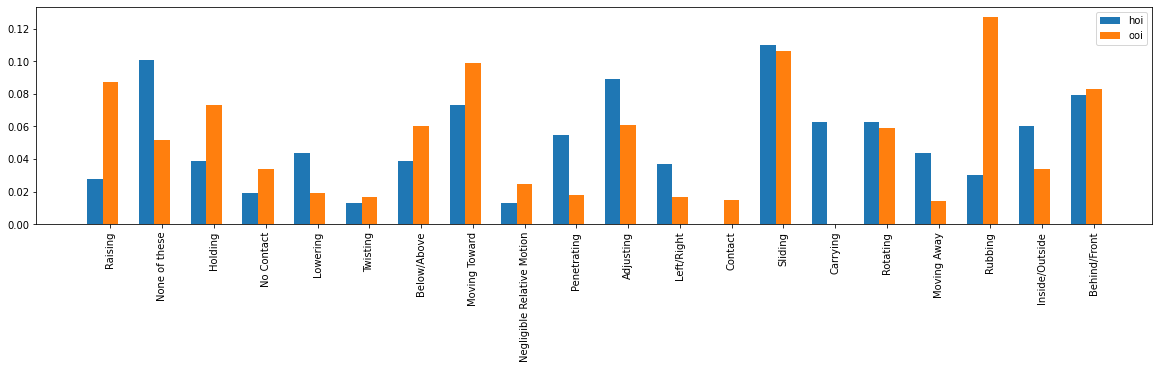

In [5]:
labels_ = {'Raising': 0, 'None of these': 1, 'Holding': 2, 'No Contact': 3, 'Lowering': 4, 'Twisting': 5, 'Below/Above': 6, 'Moving Toward': 7, 'Negligible Relative Motion': 8, 'Penetrating': 9, 'Adjusting': 10, 'Left/Right': 11, 'Contact': 12, 'Sliding': 13, 'Carrying': 14, 'Rotating': 15, 'Moving Away': 16, 'Rubbing': 17, 'Inside/Outside': 18, 'Behind/Front': 19}

labels = { labels_[k]:k for k in list( labels_.keys() ) }


importances_sk_hoi = clfs['hoi'].feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_sk_hoi = {}
for i, feature in enumerate(labels):
    feature_importance_sk_hoi[labels[i]] = round(importances_sk_hoi[i], 3)


importances_sk_ooi = clfs['ooi'].feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_sk_ooi = {}
for i, feature in enumerate(labels):
    feature_importance_sk_ooi[labels[i]] = round(importances_sk_ooi[i], 3)



importances_sk_both = clfs['both'].feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_sk_both = {}
for i, feature in enumerate(labels):
    feature_importance_sk_both[labels[i]] = round(importances_sk_both[i], 3)



from matplotlib import pyplot as plt
names = list(feature_importance_sk_hoi.keys())

values_hoi = list(feature_importance_sk_hoi.values())
values_ooi = list(feature_importance_sk_ooi.values())
values_both = list(feature_importance_sk_both.values())

print(np.sum(values_hoi), np.sum(values_ooi), np.sum(values_both))
plt.figure(figsize=(20, 4))  # width:20, height:3

plt.xticks(rotation='vertical')

width=0.3
plt.bar(np.arange(len(values_hoi)), values_hoi, width=width, tick_label=names, label='hoi')
plt.bar(np.arange(len(values_ooi)) + width, values_ooi, width=width, tick_label=names, label='ooi')
# plt.bar(np.arange(len(values_both)) + 2*width, values_both, width=width, tick_label=names, label='both')
plt.legend()
plt.show()

[0.009, 0.007, 0.014, 0.051, 0.006, 0.103, 0.133, 0.046, 0.08, 0.021, 0.011, 0.054, 0.046, 0.117, 0.042, 0.004, 0.039, 0.048, 0.082, 0.087]


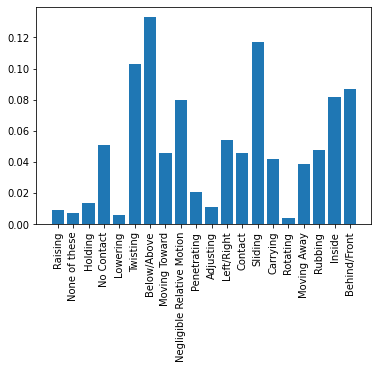

In [55]:
labels_ = {'Raising': 0, 'None of these': 1, 'Holding': 2, 'No Contact': 3, 'Lowering': 4, 'Twisting': 5, 'Below/Above': 6, 'Moving Toward': 7, 'Negligible Relative Motion': 8, 'Penetrating': 9, 'Adjusting': 10, 'Left/Right': 11, 'Contact': 12, 'Sliding': 13, 'Carrying': 14, 'Rotating': 15, 'Moving Away': 16, 'Rubbing': 17, 'Inside': 18, 'Behind/Front': 19}

labels = { labels_[k]:k for k in list( labels_.keys() ) }
          
          
importances_sk = clfs['ooi'].feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_sk = {}
for i, feature in enumerate(labels):
    feature_importance_sk[labels[i]] = round(importances_sk[i], 3)

# print(f"Feature importance by sklearn: {feature_importance_sk}")

from matplotlib import pyplot as plt
names = list(feature_importance_sk.keys())
values = list(feature_importance_sk.values())
print(values)

plt.xticks(rotation='vertical')

plt.bar(range(len(values)), values, tick_label=names)
plt.show()

In [ ]:
# # Loading the data
# X, Y = features['hoi'], features['Y']

# # Saving the feature names 
# features = X.columns.tolist()

# # Train test split 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# # Defining the hyper parameters 
# hps = {
#     'max_depth': 3,
#     'min_samples_split': 4,
#     'random_state': 0
# }

# # Loading the tree object 
# tree = DecisionTreeRegressor(**hps)

# # Fitting on the training data 
# tree.fit(X_train, y_train)

# Extracting the importances by sklearn 
importances_sk = tree.feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_sk = {}
for i, feature in enumerate(features):
    feature_importance_sk[feature] = round(importances_sk[i], 3)

print(f"Feature importance by sklearn: {feature_importance_sk}")